In [1]:
import logging
import awkward
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow import keras
from tf_keras_model import get_particle_net

In [2]:
dark_path = './data/dark_test_0.awkd'
qcd_path = './data/qcd_test_0.awkd'

In [3]:
class Dataset(object):

    def __init__(self, filepath, feature_dict = {}, label='label', pad_len=50, data_format='channel_first'):
        self.filepath = filepath
        self.feature_dict = feature_dict
        if len(feature_dict)==0:
            feature_dict['points'] = ['part_etarel', 'part_phirel']
            feature_dict['features'] = ['part_pt_log', 'part_etarel', 'part_phirel', 'part_deltaR', 'part_logptrel']
            feature_dict['mask'] = ['part_pt_log']
        self.label = label
        self.pad_len = pad_len
        assert data_format in ('channel_first', 'channel_last')
        self.stack_axis = 1 if data_format=='channel_first' else -1
        self._values = {}
        self._label = None
        self._load()

    def _load(self):
        logging.info('Start loading file %s' % self.filepath)
        counts = None
        with awkward.load(self.filepath) as a:
            self._label = a[self.label]
            for k in self.feature_dict:
                cols = self.feature_dict[k]
                if not isinstance(cols, (list, tuple)):
                    cols = [cols]
                arrs = []
                for col in cols:
                    if counts is None:
                        counts = a[col].counts
                    else:
                        assert np.array_equal(counts, a[col].counts)
                    arrs.append(pad_array(a[col], self.pad_len))
                self._values[k] = np.stack(arrs, axis=self.stack_axis)
        logging.info('Finished loading file %s' % self.filepath)


    def __len__(self):
        return len(self._label)

    def __getitem__(self, key):
        if key==self.label:
            return self._label
        else:
            return self._values[key]
    
    @property
    def X(self):
        return self._values
    
    @property
    def y(self):
        return self._label

    def shuffle(self, seed=None):
        if seed is not None:
            np.random.seed(seed)
        shuffle_indices = np.arange(self.__len__())
        np.random.shuffle(shuffle_indices)
        for k in self._values:
            self._values[k] = self._values[k][shuffle_indices]
        self._label = self._label[shuffle_indices]
        
        
def pad_array(a, maxlen, value=0, dtype='float32'):
    x = (np.ones((len(a), maxlen)) * value).astype(dtype)
    for idx, s in enumerate(a):
        if not len(s):
            continue
        trunc = s[:maxlen].astype(dtype)
        x[idx, :len(trunc)] = trunc
    return x


def lr_schedule(epoch):
    lr = 3e-4
    if 0 < epoch <= 8:
        lr = lr + epoch*3.375e-4

    elif 8 < epoch <= 16:
        lr = 3e-3 - (epoch-8)*3.375e-4
  
    elif epoch > 16:
        lr = 5e-7
    logging.info('Learning rate: %f'%lr)
    return lr

In [4]:
dark_dataset = Dataset(dark_path, data_format='channel_last')
qcd_dataset = Dataset(qcd_path, data_format='channel_last')

In [5]:
model_type = 'particle_net' # choose between 'particle_net' and 'particle_net_lite'
num_classes = dark_dataset.y.shape[1]
input_shapes = {k:dark_dataset[k].shape[1:] for k in dark_dataset.X}
if 'lite' in model_type:
    model = get_particle_net_lite(num_classes, input_shapes)
else:
    model = get_particle_net(num_classes, input_shapes)

In [6]:
path_model_checkpoints = './model_checkpoints'

file_names = []
for root, dirs, files in os.walk("./model_checkpoints"):
    for filename in files:
        file_names.append(filename)

num = []
for name in range(len(file_names)):
    x = str(file_names[name])
    numbers = x[19].split() + x[20].split() + x[21].split()
    number = numbers[0]+numbers[1]+numbers[2]
    num.append(number)

path_model = path_model_checkpoints + '/particle_net_model.' + num[0] + '.h5'

model.load_weights(path_model)

batch_size = 384

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

________________________
tf_op_layer_BatchMatMulV2_1 (Te [(None, 50, 50)]     0           tf_op_layer_Add_1[0][0]          
                                                                 tf_op_layer_Transpose_2[0][0]    
__________________________________________________________________________________________________
tf_op_layer_Mul_5 (TensorFlowOp [(None, 50, 64)]     0           tf_op_layer_Add_1[0][0]          
                                                                 tf_op_layer_Add_1[0][0]          
__________________________________________________________________________________________________
tf_op_layer_Sum_2 (TensorFlowOp [(None, 50, 1)]      0           tf_op_layer_Mul_4[0][0]          
__________________________________________________________________________________________________
tf_op_layer_Mul_6 (TensorFlowOp [(None, 50, 50)]     0           tf_op_layer_BatchMatMulV2_1[0][0]
____________________________________________________________________________________

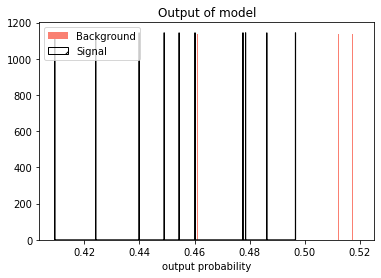

In [8]:
dark_predictions = model.predict(dark_dataset.X)
qcd_predictions = model.predict(qcd_dataset.X)

dark_pred = []
for i in range(len(dark_predictions)):
    dark_pred.append(dark_predictions[i][0])

qcd_pred = []
for i in range(len(qcd_predictions)):
    qcd_pred.append(qcd_predictions[i][0])

# 1000 bins to plot seperation
bins = 1000
qcd_values, qcd_bins, _ = plt.hist(qcd_pred, color='salmon', label='Background', bins=bins, density=True)
dark_values, dark_bins, _ = plt.hist(dark_pred, edgecolor='k', histtype='step', label='Signal', bins=bins, density=True, hatch='/')
plt.title('Output of model')
plt.xlabel('output probability')
plt.legend()
plt.savefig("./performance/Output of model qcd and dark seperated" + ".jpg")

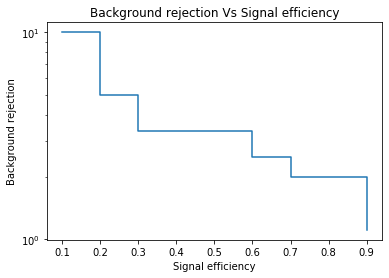

In [9]:
# plot ROC curve
total_qcd_area = sum(np.diff(qcd_bins)*qcd_values)
total_dark_area = sum(np.diff(dark_bins)*dark_values)

qcd_eff = []
dark_eff = []
for i in range(bins):
    qcd_area = sum(np.diff(qcd_bins[:i + 1])*qcd_values[:i])
    dark_area = sum(np.diff(dark_bins[:i + 1])*dark_values[:i])
    qcd_eff.append(1/(qcd_area/(total_qcd_area)))
    dark_eff.append(dark_area/(total_dark_area))

plt.semilogy(dark_eff, qcd_eff)
plt.title('Background rejection Vs Signal efficiency')
plt.xlabel('Signal efficiency')
plt.ylabel('Background rejection')
plt.savefig("./performance/Background rejection Vs Signal efficiency" + ".jpg")


df = pd.DataFrame()
column_series = pd.Series(qcd_eff)
df = df.assign(Signal_efficiency=column_series)
df = df.assign(Background_rejection=column_series)
df.to_csv('./performance/Signal_Background_DGCNN_results.csv', index=False)